# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [19]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Exploring Null values and Empty strings

In [5]:
def info(df):
    '''
    Unput: dataframe
    Output: a dataframe outlining each feature and respective number of Null values, Empty strings, percentage of Non-null values
    '''
    # Create new dataframe to fill with the exploratory data
    df_info = pd.DataFrame(columns = ['Feature','# Null values','# Empety string','% Non-null values'])

    # Counter of analyzed rows
    i = 0
    
    # Number of columns in input dataframe to be set as index in the output machine 
    row_count = df.count()
    
    # For each column:
    for col in df.columns:
        # Count null values
        null_count = df.filter(isnull(df[col])).count()
        # Count empty strings
        emptystring_count = df.filter(df[col].isin('')).count()
        # For each row, log the acquired details
        df_info.loc[i] = [col, null_count, emptystring_count, (row_count-null_count)/row_count]
        # move on to the next index (new columns)
        i += 1
    print(df_info)
    
info(df)

          Feature # Null values # Empety string  % Non-null values
0          artist         58392               0           0.796188
1            auth             0               0           1.000000
2       firstName          8346               0           0.970869
3          gender          8346               0           0.970869
4   itemInSession             0               0           1.000000
5        lastName          8346               0           0.970869
6          length         58392               0           0.796188
7           level             0               0           1.000000
8        location          8346               0           0.970869
9          method             0               0           1.000000
10           page             0               0           1.000000
11   registration          8346               0           0.970869
12      sessionId             0               0           1.000000
13           song         58392               0           0.79

In [6]:
def clean(df):
    
    row_count = df.count()
    columns_count = len(df.columns)
    
    # Drop any cells with missing user id or session id
    df_new = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
    
    # Filter out records with empty userId
    df_new = df_new.filter(df_new['userId'] != '')
    
    # Clearly represent registration and timestamp by creating new columns
    new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
    df_new = df_new.withColumn('updated_registration', new_ts('registration'))
    df_new = df_new.withColumn('updated_ts', new_ts('ts'))
    
    new_row_count = df_new.count()
    new_columns_count = len(df_new.columns)
    
    print("The number of rows in the dataframe was {}, now is {}".format(df.count(), new_row_count))
    print("The number of features in the dataframe was {}, now is {}".format(len(df.columns) ,new_columns_count))
    
    return df_new

df = clean(df)

The number of rows in the dataframe was 286500, now is 278154
The number of features in the dataframe was 18, now is 20


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Defining the Churn**

In [7]:
def define_churn(df):
    '''
    input: a dataframe
    output: the input dataframe with a new column labeling as churn or not
    '''
    # UDF function that labels the user as churn if they landed on Cancellation Confirmation or Downgrade pages
    cancelation = udf(lambda x: 1 if (x == "Cancellation Confirmation") or (x == "Submit Downgrade")  else 0, IntegerType())

    # Applying cancelation function
    df = df.withColumn("churn", cancelation("page"))

    # Defining a window to agregate each user
    window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

    # whether is the user is defined as Churn or not
    df = df.withColumn("churn", F.max("churn").over(window))
    
    return df

df = define_churn(df)

**Number of Active vs. Churn users in the database**

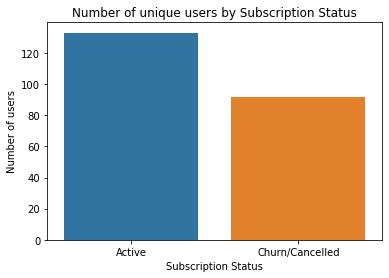

In [8]:
# Counting the number of users based on subscription status with respect to all availables log instances
pd = df.drop_duplicates(['userId']).groupBy(['churn']).count().toPandas()

# Visualisation
sns.barplot(data = pd, x = 'churn', y = 'count')

# Labeling bars
ticks = ['Active', 'Churn/Cancelled']

# Bar positioning
x_pos = np.arange(len(ticks))

# Applying ticks configurations
plt.xticks(x_pos, ticks)
plt.title('Number of unique users by Subscription Status')
plt.ylabel('Number of users')
plt.xlabel('Subscription Status');

**Gender distribution of Active vs. Churn users in the database**

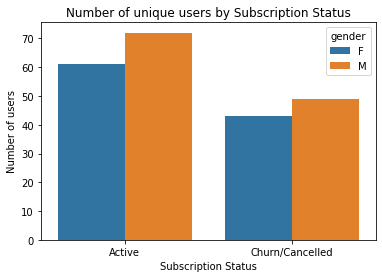

In [9]:
# Counting the number of users based on subscription status and gender with respect to all availables log instances
pd = df.drop_duplicates(['userId']).groupBy(['churn', 'gender']).count().toPandas()

# Visualisation
sns.barplot(data = pd, x = 'churn', y = 'count', hue = 'gender')

# Labeling bars
ticks = ['Active', 'Churn/Cancelled']

# Bar positioning
x_pos = np.arange(len(ticks))

# Applying ticks configurations
plt.xticks(x_pos, ticks)
plt.title('Number of unique users by Subscription Status')
plt.ylabel('Number of users')
plt.xlabel('Subscription Status');

**Pages usage of Active vs. Churn users in the database**

Text(0.5, 0, '% of envents')

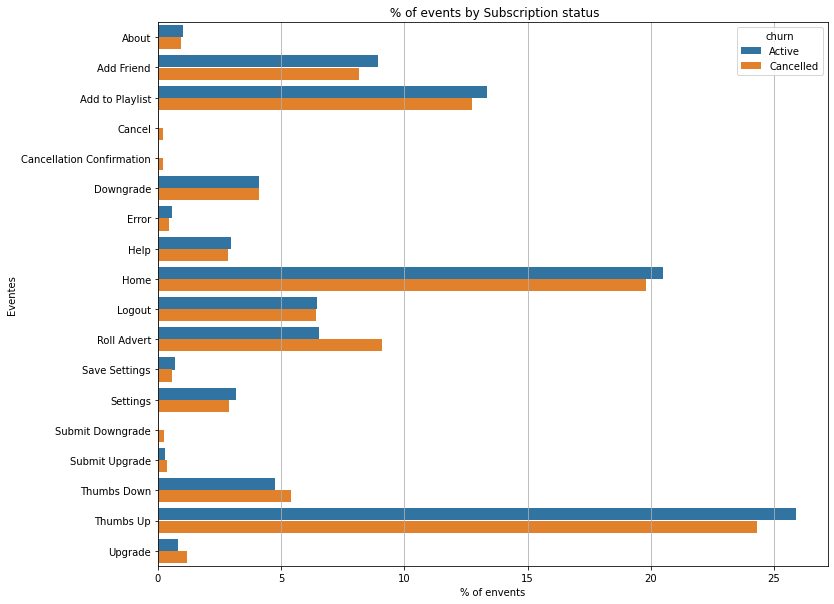

In [10]:
# counting the usage of pages and churn instances for each instance in the user log
page_df = df.groupby(['page','churn']).count().toPandas()

# Filtering out 'NextSong' event, as it is not indicative of usage patterns
page_df = page_df[page_df['page'] != 'NextSong']

# Calculating percentages to view
page_df = ((page_df.groupby(['page','churn']).sum() / page_df.groupby(['churn']).sum())*100).reset_index()

# Replacing churn 0 and 1 values with active/cancelled for ease of visualization
page_df['churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)

plt.figure(figsize=(12,10))
plt.grid(True)
sns.barplot(y = 'page', x = 'count', data = page_df, hue = 'churn')
plt.title(" % of events by Subscription status")
plt.ylabel('Eventes')
plt.xlabel('% of envents')

It could be noticed from the above chart that the significant difference between Churn and active users appears in usage of 'Roll Advert'. Advertisment could be a siginificant issue for users.

**Pages usage per day of the month**

Text(0.5, 0, 'day of month')

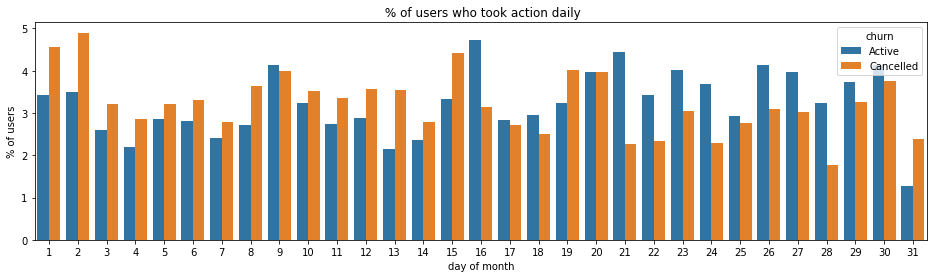

In [11]:
# Function for pulling the day information out of the timestamp
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)

# Creating a new column for the day of month
df = df.withColumn("day", get_day(df.ts))

# Counting the interactions for each day for each tupe of subscription status 'churn'
day_df = df.groupby(['day','churn']).count().toPandas()

# Calculating percentage
day_df = ((day_df.groupby(['day','churn']).sum() / day_df.groupby(['churn']).sum())*100).reset_index()

# Casting the day as an integer
day_df['day'] = day_df['day'].astype(int)

# Replacing churn 0 and 1 values with active/cancelled for ease of visualization
day_df['churn'].replace({0:'Active', 1: 'Cancelled'}, inplace = True)

# Sorting the days to appear in the right order on the month
day_df.sort_values(by = 'day', ascending = True, inplace = True)

# Visualization
plt.figure(figsize=(16,4))
sns.barplot(x = 'day', y = 'count', data = day_df, hue = 'churn')
plt.title(" % of users who took action daily")
plt.ylabel('% of users')
plt.xlabel('day of month')

It appears from the above chart that the churn users activity raises by the end of month.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
def feature_engineering(df):
    '''
    a function that takes extractes features from the original dataframe and returns it as user oriented to enable to study of the behaviour of each user.
    Input: original dataframe (user_log)
    output: a user_oriented dataframe
    '''

    # Feature 1 : Total number of songs listened by each user
    feat_1 = df.select('userId', 'song') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'song_count')

    # Feature 2 : Total time spent for each user
    feat_2 = df.select('userID', 'length') \
        .groupBy('userID') \
        .agg({'length': 'sum'}) \
        .withColumnRenamed('sum(length)', 'listen_time')

    # Feature 3 : Number of thumbs-up
    feat_3 = df.select('userID', 'page') \
        .where(df.page == 'Thumbs Up') \
        .groupBy('userID') \
        .agg({'page': 'count'}) \
        .withColumnRenamed('count(page)', 'thumb_ups')

    # Feature 4 : thumbs-down
    feat_4 = df.select('userID', 'page') \
        .where(df.page == 'Thumbs Down') \
        .groupBy('userID') \
        .agg({'page': 'count'}) \
        .withColumnRenamed('count(page)', 'thumb_downs')

    # Feature 5 : Number of adds to playlist
    feat_5 = df.select('userID', 'page') \
        .where(df.page == 'Add to Playlist') \
        .groupBy('userID') \
        .agg({'page': 'count'}) \
        .withColumnRenamed('count(page)', 'playlist_adds')

    # Feature 6 : Number of lifetime
    feat_6 = df.select('userID', 'registration', 'ts') \
        .withColumn('lifetime', (df.ts - df.registration)) \
        .groupBy('userID') \
        .agg({'lifetime': 'max'}) \
        .withColumnRenamed('max(lifetime)', 'lifetime')

    # Feature 7 : Total number of friend add requests sent
    feat_7 = df.select('userId', 'page') \
            .where(df.page == 'Add Friend') \
            .groupBy('userId') \
            .count() \
            .withColumnRenamed('count', 'friend_requests')
    
    # Feature 8 : Gender of the user
    feat_8 = df.select('userId', 'gender') \
            .dropDuplicates() \
            .replace(['F', 'M'], ['0', '1'], 'gender') \
            .select('userId', col('gender').cast('int'))
    
    # Feature 9: Number of help
    feat_9 = df.select('userID','page') \
                .where(df.page == 'Help') \
                .groupBy('userID') \
                .agg({'page':'count'}) \
                .withColumnRenamed('count(page)', 'help') 
    
    # Feature 10 : Number of rolladvert
    feat_10 = df.select('userID','page') \
                .where(df.page == 'Roll Advert') \
                .groupBy('userID') \
                .agg({'page':'count'}) \
                .withColumnRenamed('count(page)', 'rolladvert')
    
    # Feature 11 : Total number of songs listened per session
    feat_11  = df.where('page == "NextSong"') \
                .groupby(['userId', 'sessionId']) \
                .count() \
                .groupby('userId') \
                .agg({'count' : 'avg'}) \
                .withColumnRenamed('avg(count)', 'avg_played_songs')
    
    # Feature 12 : Total number of artists the user has listened to
    feat_12 = df.filter(df.page == "NextSong") \
                .select("userId", "artist") \
                .dropDuplicates() \
                .groupby("userId") \
                .count() \
                .withColumnRenamed("count", "tot_artist_played")
    
    # setting the churn label
    target = df.select('userId', col('churn').alias('label')).dropDuplicates()
    
    # Combining all features with the target churn label
    final_df  = feat_1.join(feat_2,'userID','outer') \
    .join(feat_3,'userID','outer') \
    .join(feat_4,'userID','outer') \
    .join(feat_5,'userID','outer') \
    .join(feat_6,'userID','outer') \
    .join(feat_7,'userID','outer') \
    .join(feat_8,'userID','outer') \
    .join(feat_9,'userID','outer') \
    .join(feat_10,'userID','outer') \
    .join(feat_11,'userID','outer') \
    .join(feat_12,'userID','outer') \
    .join(target,'userID','outer') \
    .drop('userID') \
    .fillna(0)
    
    # Final dataframe columns names
    inputcols = ['song_count',
     'listen_time',
     'thumb_ups',
     'thumb_downs',
     'playlist_adds',
     'lifetime',
     'friend_requests',
     'gender',
     'help',
     'rolladvert',
     'avg_played_songs',
     'tot_artist_played']
    
    # Combining created features into a single feature for ease of modelling
    
    # Instintiating a Vector assembler
    assembler = VectorAssembler(inputCols = inputcols, outputCol = "NumFeatures")
    
    # Application of assembler on the final form of data
    final_df = assembler.transform(final_df)
    
    # Selecting features and label
    final_df = final_df.select(['label','NumFeatures'])
    
    # Splitting into train and test 
    train, test = final_df.randomSplit([0.8, 0.2], seed = 1)
    
    # Scaling the input features 
    stscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
    
    # Fit the scaler only on training set
    scalerModel = stscaler.fit(train)
    
    # Transformation of train and test sets
    train = scalerModel.transform(train)
    test = scalerModel.transform(test)
    
    return train, test

train, test = feature_engineering(df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [20]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam =0.0)

gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)

svm = LinearSVC (maxIter = 10,  regParam = 0.01)

In [21]:
# Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName = 'f1')

# A param grid to test model over
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()

# Applying cross validation instance
crossval = CrossValidator(estimator = logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

# fitting the cross validation 
cvModel_q1 = crossval.fit(train)

# Returning the values acquired by the cross validation over the paramgrid
cvModel_q1.avgMetrics

[0.6146469801842698, 0.6288399077982244, 0.6178544554854115]

In [22]:
# Support Vector Machine 
e1 = MulticlassClassificationEvaluator(metricName='f1')

# A param grid to test model over
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()

# Applying cross validation instance
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

# fitting the cross validation 
cvModel_q2 = crossval.fit(train)

# Returning the values acquired by the cross validation over the paramgrid
cvModel_q2.avgMetrics

[0.5646695016450868, 0.5803783785381742, 0.5412244374613481]

In [23]:
# Gradient boosted tree
e1 = MulticlassClassificationEvaluator(metricName='f1')

# A param grid to test model over
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()

# Applying cross validation instance
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

# fitting the cross validation 
cvModel_q3 = crossval.fit(train)

# Returning the values acquired by the cross validation over the paramgrid
cvModel_q3.avgMetrics

[0.6135204744393379, 0.6103340731650645]

In [24]:
gbt_tuned = GBTClassifier(maxDepth = 5, maxIter = 20 ,seed = 1)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.652771746996671


In [25]:
gbt_model.featureImportances

SparseVector(12, {0: 0.0793, 1: 0.0324, 2: 0.1257, 3: 0.1151, 4: 0.0835, 5: 0.1308, 6: 0.0897, 7: 0.0192, 8: 0.0305, 9: 0.1796, 10: 0.0581, 11: 0.0561})

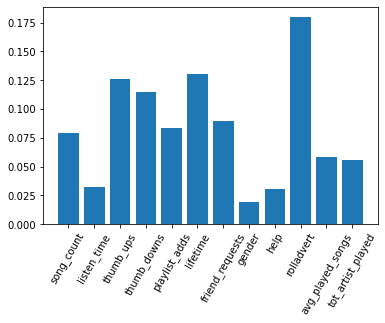

In [30]:
features_importance = [('song_count',0.0793),
     ('listen_time',0.0324),
     ('thumb_ups',0.1257),
     ('thumb_downs',0.1151),
     ('playlist_adds',0.0835),
     ('lifetime',0.1308),
     ('friend_requests',0.0897),
     ('gender',0.0192),
     ('help',0.0305),
     ('rolladvert',0.1796),
     ('avg_played_songs',0.0581),
     ('tot_artist_played',0.0561)]

plt.bar(range(len(features_importance)), [val[1] for val in features_importance], align='center')
plt.xticks(range(len(features_importance)), [val[0] for val in features_importance])
plt.xticks(rotation=60)
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.